### ----------------------------------------------------------------------------------------------------------
## 社会変革型 ライフサイエンス・ヘルスケア データサイエンティスト育成講座
# 多変量解析 講義用資料
### ----------------------------------------------------------------------------------------------------------

## 2. 統計的解析と仮説検定、検出力 

In [1]:
# 必要なライブラリのインポート

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, t
%matplotlib inline

In [2]:
# サンプルサイズ計算のための関数定義

def ssize(data,two_sided=True):
    if two_sided:
        z_alpha = norm.ppf(1-data['alpha']/2)
    else:
        z_alpha = norm.ppf(1-data['alpha'])
    z_beta = norm.ppf(1-data['beta'])
    n = np.power(data['sigma']/data['effect'],2)*np.power((z_alpha+z_beta),2)
    return n

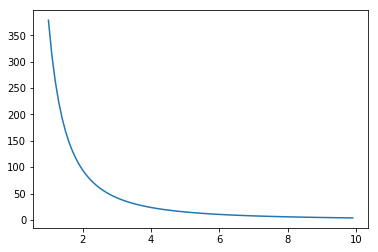

In [3]:
# 練習問題解答例

test_data = {'effect':3,
             'sigma':6,
             'alpha':0.05,
             'beta':0.1}

n = ssize(test_data)
datapoints = np.arange(1,10,0.1)
nn = np.zeros([datapoints.shape[0],1])
for i in range(len(datapoints)):
    test_data['effect'] = datapoints[i]
    nn[i] = ssize(test_data)
    
plt.plot(datapoints,nn)
plt.show()

## 3-1. 単回帰

In [4]:
# サンプル生成用関数の定義

def generate_sample(params,nsample=20,xrange=[0,10]):
    rsample = np.zeros([nsample,2])
    for i in range(nsample):
        err = np.random.normal(0,params['sigma'],1)
        x = np.random.uniform(xrange[0],xrange[1],1)
        y = params['b_1'] + params['b_2']*x + err
        rsample[i,:] = y[0],x
        
    return rsample

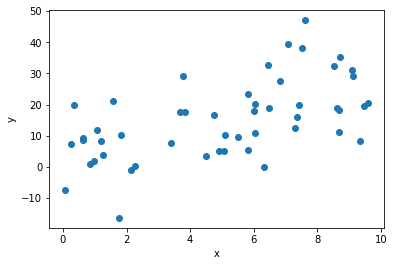

In [5]:
# 試しにサンプルを生成してプロット

params = {'b_1':3,
          'b_2':2.5,
          'sigma':10
          }

rsample = generate_sample(params,nsample=50)
plt.scatter(rsample[:,1],rsample[:,0])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
# 練習問題解答例

def fit_lrmodel(rsample):
    params_est = dict()
    den, num = 0, 0
    df = rsample.shape[0]-2
    
    # parameter estimation
    means = np.average(rsample,0)
    for y,x in rsample:
        den += np.power(x-means[1],2)
        num += (x-means[1])*(y-means[0])
        
    params_est['b_2'] = num/den
    params_est['b_1'] = means[0] - params_est['b_2']*means[1]
    
    # error
    err = 0
    for y,x in rsample:
        err += np.power(y - (params_est['b_1']+params_est['b_2']*x),2)
    params_est['err'] = err/df
    
    # variance of b_2
    params_est['v_b2'] = params_est['err']/den
    
    # t-test
    params_est['t'] = params_est['b_2']/np.sqrt(params_est['v_b2'])
    params_est['p-value'] = (1 - t.cdf(params_est['t'],df))*2
    
    # r-square
    den_r2, num_r2 = 0, 0
    for y,x in rsample:
        y_hat = params_est['b_1']+params_est['b_2']*x
        den_r2 += np.power(y-means[0],2)
        num_r2 += np.power(y_hat-means[0],2)
    params_est['r_2'] = num_r2/den_r2
    
    return params_est


def plot_lsresult(rsample,params_est,title=''):
    plt.scatter(rsample[:,1],rsample[:,0],
               c='orange')
    x = np.arange(0,10,0.1)
    y = [params_est['b_1']+params_est['b_2']*xx for xx in x]
    plt.xlim(0,10)
    plt.plot(x,y)
    plt.title(title)
    plt.show()

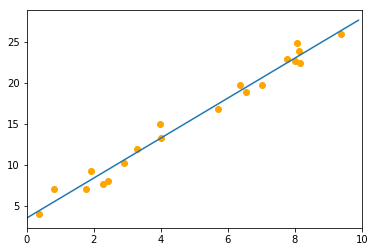

{'b_2': 2.4306226271969873, 'b_1': 3.5572816639937646, 'err': 0.9576884504256533, 'v_b2': 0.006126783906325689, 't': 31.052834957427518, 'p-value': 0.0, 'r_2': 0.9816752591848479}


In [7]:
# fit model

params = {'b_1':3,
          'b_2':2.5,
          'sigma':1}

rsample = generate_sample(params)
params_est = fit_lrmodel(rsample)
plot_lsresult(rsample,params_est)

print(params_est)

In [8]:
# linear regression with statsmodels

x = sm.add_constant(rsample[:,1])
mod = sm.OLS(rsample[:,0], x)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     964.3
Date:                Fri, 08 Mar 2019   Prob (F-statistic):           4.36e-17
Time:                        08:09:02   Log-Likelihood:                -26.893
No. Observations:                  20   AIC:                             57.79
Df Residuals:                      18   BIC:                             59.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5573      0.444      8.006      0.0

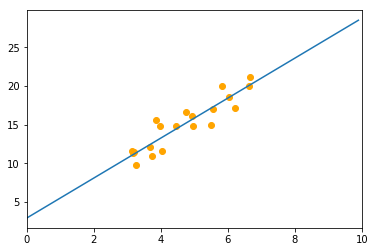

In [9]:
# xrange 3-7

params = {'b_1':3,
          'b_2':2.5,
          'sigma':1}

rsample = generate_sample(params,xrange=[3,7])
params_est = fit_lrmodel(rsample)
plot_lsresult(rsample,params_est)

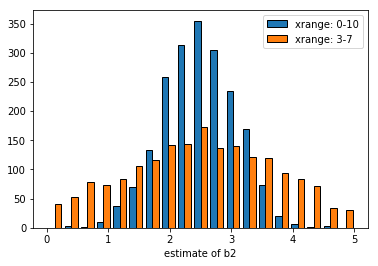

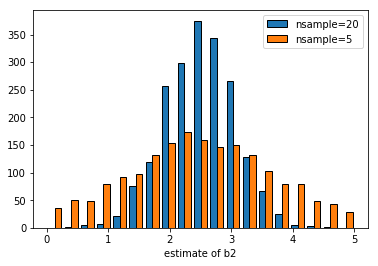

In [10]:
# 回帰係数のばらつき

params = {'b_1':3,
          'b_2':2.5,
          'sigma':7
          }

niter = 2000

# データ点のxの範囲への依存性
var_b_2 = np.zeros([niter,2])
for i in range(niter):
    rsample = generate_sample(params)
    params_est = fit_lrmodel(rsample)
    var_b_2[i,0] = params_est['b_2']
    
    rsample = generate_sample(params,xrange=[3,7])
    params_est = fit_lrmodel(rsample)
    var_b_2[i,1] = params_est['b_2']

plt.hist(var_b_2,bins=np.linspace(0,5,20),edgecolor='k')
plt.legend(['xrange: 0-10', 'xrange: 3-7'])
plt.xlabel('estimate of b2')
plt.show()


# データ点の数への依存性
var_b_2 = np.zeros([niter,2])
for i in range(niter):
    rsample = generate_sample(params)
    params_est = fit_lrmodel(rsample)
    var_b_2[i,0] = params_est['b_2']
    
    rsample = generate_sample(params,nsample=5)
    params_est = fit_lrmodel(rsample)
    var_b_2[i,1] = params_est['b_2']

plt.hist(var_b_2,bins=np.linspace(0,5,20),edgecolor='k')
plt.legend(['nsample=20', 'nsample=5'])
plt.xlabel('estimate of b2')
plt.show()

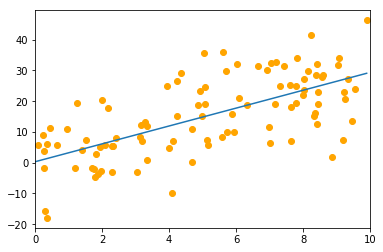

In [11]:
# qq plot用のデータの準備

params_1 = {'b_1':3,
          'b_2':2.5,
          'sigma':10}

rsample_1 = generate_sample(params_1,nsample=100)

params_est_1 = fit_lrmodel(rsample_1)
plot_lsresult(rsample_1,params_est_1)

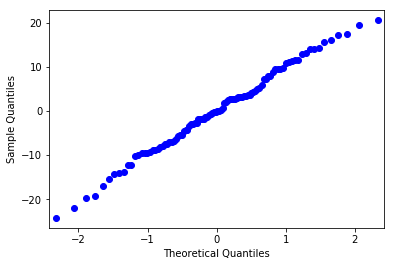

In [12]:
# qq plot
# statsmodelsを用いてモデル作成→各データ点について誤差を計算

rsample_1_x = sm.add_constant(rsample_1[:,1])
mod_fit = sm.OLS(rsample_1[:,0],rsample_1_x).fit()

# 'resid'関数を使用して誤差を計算
res = mod_fit.resid

# 'qqplot'関数を使用してプロットを作成
fig = sm.qqplot(res)
plt.show()

## 3-2. 重回帰

In [13]:
# サンプル生成関数の定義

def generate_sample_2d(params,nsample=50,xrange=[[0,10],[0,10]],collinear=False):
    rsample = np.zeros([nsample,3])
    for i in range(nsample):
        err = np.random.normal(0,params['sigma'],1)
        if collinear:
            err_collin = np.random.normal(0,params['sigma_collin'],1)
            x_1 = np.random.uniform(xrange[0][0],xrange[0][1],1)
            x_2 = x_1*params['b_2_collin']+err_collin          
        else:
            x_1 = np.random.uniform(xrange[0][0],xrange[0][1],1)
            x_2 = np.random.uniform(xrange[1][0],xrange[1][1],1)
        y = params['b_1'] + params['b_2']*x_1 + params['b_3']*x_2 + err
        rsample[i,:] = y[0],x_1,x_2
        
    return rsample

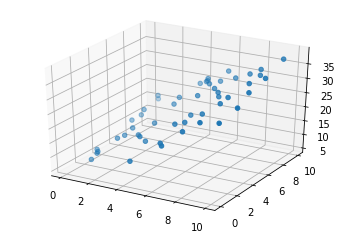

In [14]:
# 試しにプロット

from mpl_toolkits.mplot3d import Axes3D

params = {'b_1': 3,
          'b_2': 2.5,
          'b_3': 1.2,
          'sigma': 1
          }

rsample = generate_sample_2d(params)
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rsample[:,1],rsample[:,2],rsample[:,0])
plt.show()

In [15]:
# statsmodelsを使用してモデルをフィッティングします

params = {'b_1': 3,
          'b_2': 2.5,
          'b_3': 1.2,
          'sigma': 7
          }
rsample = generate_sample_2d(params,nsample=100)

# 定数に相当する列をデータに付加
x = sm.add_constant(rsample[:,1:])

mod = sm.OLS(rsample[:,0], x)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     65.99
Date:                Fri, 08 Mar 2019   Prob (F-statistic):           8.08e-19
Time:                        08:09:08   Log-Likelihood:                -334.47
No. Observations:                 100   AIC:                             674.9
Df Residuals:                      97   BIC:                             682.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3233      1.931      0.685      0.4

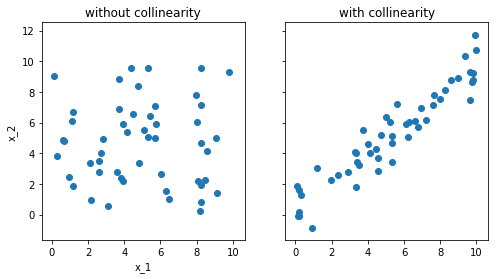

In [16]:
# 多重共線性ありの場合のサンプル生成

params = {'b_1': 3,
          'b_2': 2.5,
          'b_3': 1.2,
          'sigma': 7,
          'sigma_collin': 1,
          'b_2_collin': 1
          }

fig, ax = plt.subplots(1,2,figsize=[8,4],sharex=True,sharey=True)
rsample_1 = generate_sample_2d(params)
rsample_2 = generate_sample_2d(params,collinear=True)

ax[0].scatter(rsample_1[:,1],rsample_1[:,2])
ax[0].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[0].set_title('without collinearity')
ax[1].scatter(rsample_2[:,1],rsample_2[:,2])
ax[1].set_title('with collinearity')
plt.show()

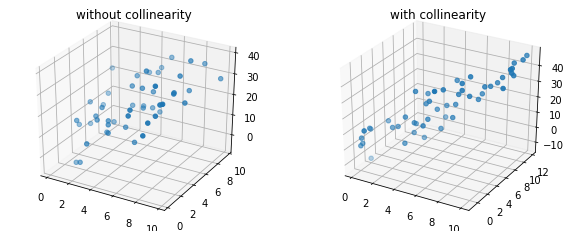

In [17]:
# 3d plot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,4]) 
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(rsample_1[:,1],rsample_1[:,2],rsample_1[:,0])
ax1.set_title('without collinearity')
ax2.scatter(rsample_2[:,1],rsample_2[:,2],rsample_2[:,0])
ax2.set_title('with collinearity')
plt.show()

In [18]:
# 多重共線性が認められるデータに対するモデル当てはめ

params = {'b_1': 3,
          'b_2': 2.5,
          'b_3': 1.2,
          'sigma': 7,
          'sigma_collin': 1,
          'b_2_collin': 1
          }

rsample = generate_sample_2d(params,nsample=100,collinear=True)
x = sm.add_constant(rsample[:,1:])
mod = sm.OLS(rsample[:,0], x)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     128.1
Date:                Fri, 08 Mar 2019   Prob (F-statistic):           5.98e-28
Time:                        08:09:08   Log-Likelihood:                -327.77
No. Observations:                 100   AIC:                             661.5
Df Residuals:                      97   BIC:                             669.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2819      1.307      1.746      0.0

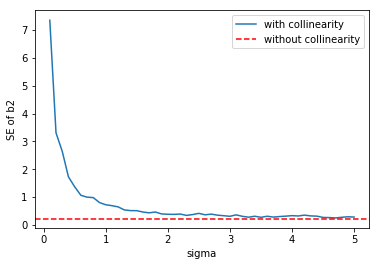

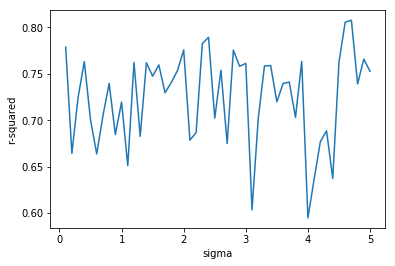

In [19]:
# 練習問題 (重回帰) 解答例

params = {'b_1': 3,
          'b_2': 2.5,
          'b_3': 1.2,
          'sigma': 7,
          'sigma_collin': 1,
          'b_2_collin': 1
          }

# sigmaを0.1ずつ変化させる
sigma_ = np.linspace(0.1,5,50)

# 空の配列を作成しておく
r_2 = np.zeros([len(sigma_),1]) 
b_2_se = np.zeros([len(sigma_),1])

# sigmaの数だけループを回す
for i,s in enumerate(sigma_):
    
    # sigmaをループごとに変化させていく
    params['sigma_collin'] = s
    
    # モデルフィッティング
    rsample = generate_sample_2d(params,nsample=100,collinear=True)
    x = sm.add_constant(rsample[:,1:])
    mod = sm.OLS(rsample[:,0], x)
    res = mod.fit()
    
    # 決定係数と回帰係数
    r_2[i] = res.rsquared
    b_2_se[i] = res.bse[1]
    
# プロット
plt.plot(sigma_,b_2_se)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.xlabel('sigma')
plt.ylabel('SE of b2')
plt.legend(['with collinearity','without collinearity'])
plt.show()

plt.plot(sigma_,r_2)
plt.xlabel('sigma')
plt.ylabel('r-squared')
plt.show()

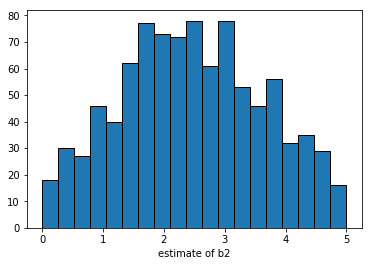

In [20]:
# 多重共線性存在下でのパラメータ推定値のヒストグラム

niter = 1000
b_2_est = np.zeros([niter,1])
params['sigma_collin'] = 0.5

for i in range(niter):
    rsample = generate_sample_2d(params,nsample=100,collinear=True)
    x = sm.add_constant(rsample[:,1:])
    mod = sm.OLS(rsample[:,0], x)
    res = mod.fit()
    b_2_est[i] = res.params[1]

plt.hist(b_2_est,bins=np.linspace(0,5,20),edgecolor='k')
plt.xlabel('estimate of b2')
plt.show()

In [21]:
# 分散拡大係数の計算

from statsmodels.stats.outliers_influence import variance_inflation_factor

params['sigma_collin'] = 1
rsample = generate_sample_2d(params,nsample=100,collinear=True)
vif = variance_inflation_factor(rsample[:,1:],0)
print(vif)

32.95066567195657


## 5. ロジスティック回帰

In [22]:
# pima indiansデータの読み込み

# Jupyter Notebookのホームディレクトリに下記csvファイルを格納してください
filename = "pima-indians-diabetes.data.csv"

df = pd.read_csv(filename, sep=',',
                 names=[
                     'Pregnancies',
                     'Glucose',
                     'Blood Pressure',
                     'Skin Thickness',
                     'Insulin',
                     'BMI',
                     'Diabetes Pedigree Function',
                     'Age',
                     'Outcome'
                 ]
                )

# 平均値による欠損値の補完 
imputer_cols = df.columns[[1,2,3,4,5,6]]
correct_df = df.copy()

for i in imputer_cols:
    correct_df[i] = correct_df[i].mask(df[i]==0, df[i].mean())

correct_df.head()

,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree Function,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [23]:
# 後で使用するバープロット用の関数定義

def plot_category_odds(data):
    odds_ratio = np.zeros([3,1])
    for i in range(3):
        odds_ratio[i] = data[2*i+1]/data[2*i]

    left = np.array([1,2,3])
    labels = [l for l in group_summary.index.levels[0]]
    plt.bar(left,odds_ratio[:,0],tick_label=labels)
    plt.ylabel('odds ratio')
    plt.show()

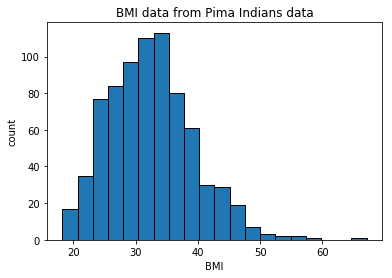

In [24]:
# BMIデータの確認

plt.hist(correct_df['BMI'],bins=20,edgecolor='k')
plt.xlabel('BMI')
plt.ylabel('count')
plt.title('BMI data from Pima Indians data')
plt.show()

In [25]:
# オッズ比の計算

tmp = pd.cut(correct_df['BMI'],[0,30,100])
a = pd.concat([tmp,correct_df['Outcome']],axis=1)
a.groupby(['BMI','Outcome']).size()

BMI        Outcome
(0, 30]    0          241
           1           51
(30, 100]  0          259
           1          217
dtype: int64

In [26]:
# statsmodelsを使用したロジスティック回帰

# BMIをカテゴリデータ化
data_BMI_cat = pd.cut(correct_df['BMI'],[0,30,100],labels=[0,1])

# Outcomeを結合
data_BMI_cat = pd.concat([data_BMI_cat,correct_df['Outcome']],axis=1)

print(data_BMI_cat.head())

  BMI  Outcome
0   1        1
1   0        0
2   0        1
3   0        0
4   1        1


In [27]:
# モデルのフィッティング

import statsmodels.formula.api as smf

# 説明変数の指定
f = 'Outcome ~ BMI'
logitfit = smf.logit(formula=str(f), data=data_BMI_cat).fit()

print(logitfit.summary())

# パラメータは対数オッズ比を表すため、expの肩に乗せることでオッズ比を算出
print('odds ratio = ' + str(np.exp(logitfit.params[1])))

# 回帰係数のp value
print('p-value = ' + str(logitfit.pvalues[1]))

Optimization terminated successfully.
         Current function value: 0.603302
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Mar 2019   Pseudo R-squ.:                 0.06725
Time:                        08:09:11   Log-Likelihood:                -463.34
converged:                       True   LL-Null:                       -496.74
                                        LLR p-value:                 2.986e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5530      0.154    -10.075      0.000      -1.855      -1.251
BMI[T.1]       1.3760      0.

In [28]:
# BMIを連続変数のまま、説明変数として使用するモデル

# BMIを説明変数として指定
f = 'Outcome ~ BMI'
logitfit = smf.logit(formula=str(f), data=correct_df).fit()

# オッズ比を算出
print('odds ratio = ' + str(np.exp(logitfit.params[1])))

# 回帰係数のp value
print('p-value = ' + str(logitfit.pvalues[1]))

print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.596671
         Iterations 5
odds ratio = 1.1083359360782852
p-value = 3.703082560298689e-16
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Mar 2019   Pseudo R-squ.:                 0.07750
Time:                        08:09:11   Log-Likelihood:                -458.24
converged:                       True   LL-Null:                       -496.74
                                        LLR p-value:                 1.712e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0190      0.429     -9.363 

       BMI  Outcome
0  obesity        1
1   medium        0
2   normal        1
3   medium        0
4  obesity        1


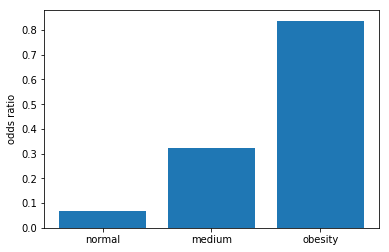

Optimization terminated successfully.
         Current function value: 0.591633
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Mar 2019   Pseudo R-squ.:                 0.08529
Time:                        08:09:11   Log-Likelihood:                -454.37
converged:                       True   LL-Null:                       -496.74
                                        LLR p-value:                 3.980e-19
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.7081      0.390     -6.937      0.000      -3.473      -1.943
BMI[T.medium]    

In [29]:
# BMIを3カテゴリに分けて使用

data_BMI_cat_3 = pd.cut(correct_df['BMI'],[0,25,30,100],labels=['normal','medium','obesity'])
data_BMI_cat_3 = pd.concat([data_BMI_cat_3,correct_df['Outcome']],axis=1)
group_summary = data_BMI_cat_3.groupby(['BMI','Outcome']).size()
print(data_BMI_cat_3.head())

plot_category_odds(group_summary)

f = 'Outcome ~ BMI'
logitfit = smf.logit(formula=str(f), data=data_BMI_cat_3).fit()

print(logitfit.summary())

In [30]:
# sample generation関数の定義

def generate_sample_logit_2d(params,nsample=50,xrange=[[0,10],[0,10]],collinear=False):
    rsample = np.zeros([nsample,3])
    for i in range(nsample):
        threshold = np.random.rand()
        if collinear:
            err_collin = np.random.normal(0,params['sigma_collin'],1)
            x_2 = np.random.uniform(xrange[1][0],xrange[1][1],1)
            x_1 = x_2*params['b_collin']+err_collin
        else:
            x_1 = np.random.uniform(xrange[0][0],xrange[0][1],1)
            x_2 = np.random.uniform(xrange[1][0],xrange[1][1],1)
            
        t = params['b_1'] + params['b_2']*x_1 + params['b_3']*x_2
        p = 1/(1+np.exp(-t))
        if p>=threshold: y=1 
        else: y=0
                    
        rsample[i,:] = y,x_1,x_2  
    out = pd.DataFrame(rsample)
    out.columns = ['y','x_1','x_2']
    return out

In [31]:
# 可視化のための関数定義

def plot_scatter(df_pos,df_neg,cols=['x_1','x_2'],dsize=10):
    plt.scatter(df_pos[cols[0]],df_pos[cols[1]],
                c='orange',
                s=dsize,
                label='positive',
               )
    plt.scatter(df_neg[cols[0]],df_neg[cols[1]],
                c='blue',
                s=dsize,
                label='negative',
                alpha=0.3, 
               )

    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.legend()
    
    
def plot_bar(df_pos,df_neg,cols=['x_1','x_2']):
    fig, ax = plt.subplots(1,len(cols))
    for i,col in enumerate(cols):
        ax[i].bar([1,2],[df_neg[col].mean(),df_pos[col].mean()],tick_label=['neg','pos'])
        ax[i].set_title(col)
    plt.show()
    
    
def plot_scatter_heat(df_pos,df_neg,res,cols=['x_1','x_2'],dsize=10,interaction=False):
    min_x1 = np.min([np.min(df_pos[cols[0]]),np.min(df_neg[cols[0]])])
    max_x1 = np.max([np.max(df_pos[cols[0]]),np.max(df_neg[cols[0]])])
    min_x2 = np.min([np.min(df_pos[cols[1]]),np.min(df_neg[cols[1]])])
    max_x2 = np.max([np.max(df_pos[cols[1]]),np.max(df_neg[cols[1]])])
                     
    x1 = np.linspace(min_x1,max_x1,50)
    x2 = np.linspace(min_x2,max_x2,50)
    
    prediction = np.zeros([50,50])
    for i in range(50):
        for j in range(50):
            if interaction:
                prediction[i,j] = res.predict({'x_1':x1[i],'x_2':x2[j]})[0]
            else:
                prediction[i,j] = res.predict([1,x1[i],x2[j]])[0]
            
    extent = [min_x1, max_x1, min_x2, max_x2]

    fig = plt.figure(figsize=[6,6])
    ax = fig.add_subplot(1,1,1)

    plot_scatter(df_pos,df_neg,dsize=15)

    im = ax.imshow(prediction.T,
                   extent=extent,
                   origin='lower',
                   cmap='pink'
                  )
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    plt.show()

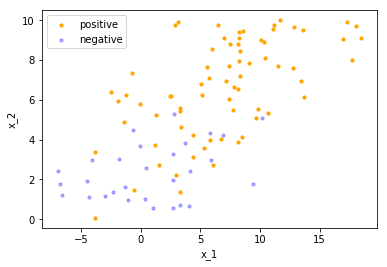

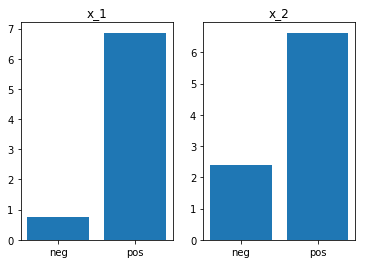

In [32]:
# サンプル生成→可視化

params = {'b_1': -3,
          'b_2': 0.01,
          'b_3': 1,
          'b_collin': 1,
          'sigma_collin': 4}

rsample = generate_sample_logit_2d(params,nsample=100,collinear=True)
rsample_pos = rsample[rsample['y']==1]
rsample_neg = rsample[rsample['y']==0]

plot_scatter(rsample_pos,rsample_neg)
plot_bar(rsample_pos,rsample_neg)

In [33]:
# モデルによるフィッティング

X = sm.add_constant(rsample[['x_1','x_2']])
logit_mod = sm.Logit(rsample['y'], X)
logit_res = logit_mod.fit(disp=0)

print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Mar 2019   Pseudo R-squ.:                  0.4668
Time:                        08:09:12   Log-Likelihood:                -32.108
converged:                       True   LL-Null:                       -60.215
                                        LLR p-value:                 6.210e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7330      0.718     -3.807      0.000      -4.140      -1.326
x_1            0.0664      0.077      0.858      0.391      -0.085       0.218
x_2            0.8055      0.195      4.131      0.0

/Users/dfractal_mbp006/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


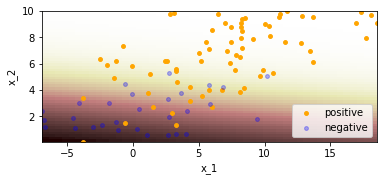

In [34]:
# 結果の可視化

plot_scatter_heat(rsample_pos,rsample_neg,logit_res)

In [35]:
# 交互作用ありの場合のサンプル生成関数

def generate_sample_logit_2d_int(params,nsample=50,xrange=[[0,10],[0,10]],interaction=False):
    rsample = np.zeros([nsample,3])
    for i in range(nsample):
        threshold = np.random.rand()
        x_1 = np.random.uniform(xrange[0][0],xrange[0][1],1)
        x_2 = np.random.uniform(xrange[1][0],xrange[1][1],1)
        if interaction:
            t = params['b_1'] + params['b_2']*x_1 + params['b_3']*x_2 + params['int']*x_1*x_2
        else:
            t = params['b_1'] + params['b_2']*x_1 + params['b_3']*x_2
            
        p = 1/(1+np.exp(-t))
        if p>=threshold: y=1 
        else: y=0
                    
        rsample[i,:] = y,x_1,x_2  
    out = pd.DataFrame(rsample)
    out.columns = ['y','x_1','x_2']
    return out

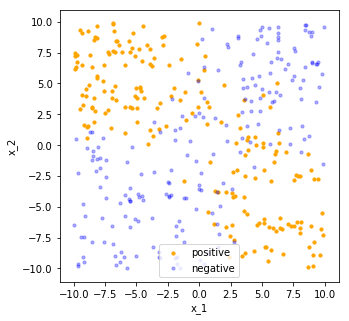

In [36]:
# 交互作用ありの場合のデータ

params = {'b_1': -0.3,
          'b_2': 0.2,
          'b_3': 0.2,
          'int': -0.2
          }

rsample = generate_sample_logit_2d_int(params,nsample=400,xrange=[[-10,10],[-10,10]],interaction=True)
rsample_pos = rsample[rsample['y']==1]
rsample_neg = rsample[rsample['y']==0]

plt.figure(figsize=[5,5])
plot_scatter(rsample_pos,rsample_neg)

In [37]:
# 交互作用を仮定しないロジスティックモデルによるフィッティング

import statsmodels.formula.api as smf

f = 'y ~ x_1+x_2'
logitfit = smf.logit(formula = str(f), data = rsample).fit()

print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.685220
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Mar 2019   Pseudo R-squ.:                 0.01142
Time:                        08:09:12   Log-Likelihood:                -274.09
converged:                       True   LL-Null:                       -277.25
                                        LLR p-value:                   0.04218
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0341      0.101     -0.336      0.737      -0.233       0.164
x_1           -0.0245      0.

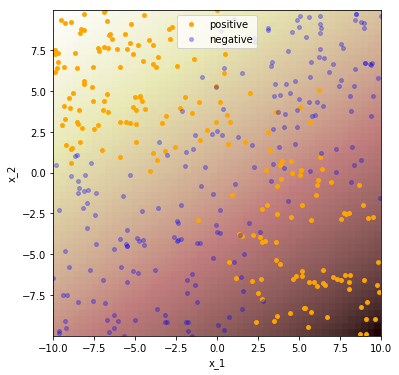

In [38]:
# 結果の可視化

plot_scatter_heat(rsample_pos,rsample_neg,logitfit,interaction=True)

In [39]:
# 交互作用を仮定したロジスティックモデルによるフィッティング

f = 'y ~ x_1*x_2'
logitfit = smf.logit(formula = str(f), data = rsample).fit()

print(logitfit.summary())

Optimization terminated successfully.
         Current function value: 0.250364
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Mar 2019   Pseudo R-squ.:                  0.6388
Time:                        08:09:16   Log-Likelihood:                -100.15
converged:                       True   LL-Null:                       -277.25
                                        LLR p-value:                 1.823e-76
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4589      0.190     -2.414      0.016      -0.831      -0.086
x_1            0.1308      0.

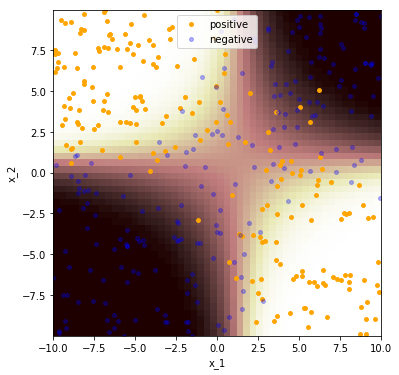

In [40]:
# 結果の可視化

plot_scatter_heat(rsample_pos,rsample_neg,logitfit,interaction=True)

## 6. 生存分析

In [41]:
# データとライブラリの準備

from lifelines import datasets, KaplanMeierFitter
from lifelines.plotting import plot_lifetimes

gbsg2_data = datasets.load_gbsg2()
gbsg2_data.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


## German Breast Cancer Study Group 2
contains the observations of 686 women  
http://ugrad.stat.ubc.ca/R/library/ipred/html/GBSG2.html

| column name | variables |
|:---------|:----------|
| horTh | hormonal therapy, a factor at two levels no and yes |
| age | of the patients in years |
| menostat | menopausal status, a factor at two levels pre (premenopausal) and post (postmenopausal) |
| tsize | tumor size (in mm) |
| tgrade | tumor grade, a ordered factor at levels I < II < III |
| pnodes | number of positive nodes |
| progrec | progesterone receptor (in fmol) |
| estrec | estrogen receptor (in fmol) |
| time | recurrence free survival time (in days) | 
| cens | censoring indicator (0- censored, 1- event) | 

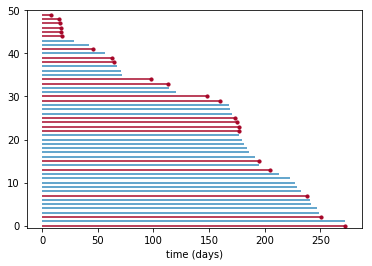

In [42]:
# timeデータの可視化

time = gbsg2_data['time']
event = gbsg2_data['cens']

time_sorted = time.sort_values().values
plot_lifetimes(time_sorted[:50], event_observed=event[:50])
plt.xlabel('time (days)')
plt.show()

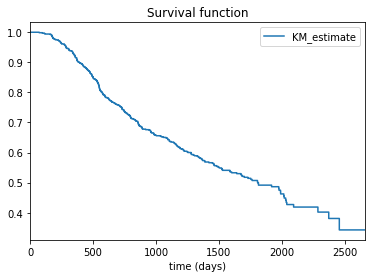

In [43]:
# Kaplan-meier曲線の描画

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed=event)

kmf.plot(ci_show=False)
plt.title('Survival function')
plt.xlabel('time (days)')
plt.show()

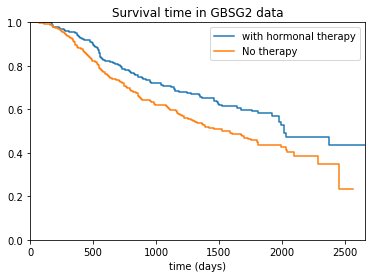

In [44]:
# ホルモン療法の有無で比較

ax = plt.subplot(111)

therapy = (gbsg2_data["horTh"] == "yes")

kmf.fit(time[therapy], event_observed=event[therapy], label="with hormonal therapy")
kmf.plot(ax=ax,ci_show=False)
kmf.fit(time[~therapy], event_observed=event[~therapy], label="No therapy")
kmf.plot(ax=ax,ci_show=False)

plt.ylim(0, 1)
plt.xlabel('time (days)')
plt.title("Survival time in GBSG2 data")
plt.show()

In [45]:
# log-rank検定

from lifelines.statistics import logrank_test

results = logrank_test(time[therapy], time[~therapy], event[therapy], event[~therapy], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99

---
 test_statistic      p  -log2(p)
           8.56 <0.005      8.19


Iteration 1: norm_delta = 0.68745, step_size = 0.9500, ll = -1788.10474, newton_decrement = 60.32574, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.28895, step_size = 0.9500, ll = -1771.78287, newton_decrement = 28.62361, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.08491, step_size = 0.9500, ll = -1739.63848, newton_decrement = 3.40632, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.02272, step_size = 1.0000, ll = -1735.92113, newton_decrement = 0.18263, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00120, step_size = 1.0000, ll = -1735.73257, newton_decrement = 0.00047, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -1735.73210, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 6 iterations.
<lifelines.CoxPHFitter: fitted with 686 observations, 387 censored>
      duration col = 'time'
         event col = 'cens'
number of subjects = 686
  number of events = 299
    log-likelihood =

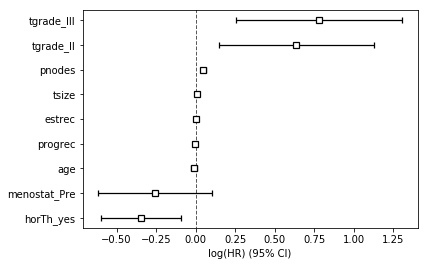

In [46]:
# cox model

from lifelines import CoxPHFitter

cph = CoxPHFitter()
gbsg2_data_dm = pd.get_dummies(gbsg2_data,columns=['horTh','menostat','tgrade'],drop_first=True)
cph.fit(gbsg2_data_dm, duration_col='time', event_col='cens', show_progress=True)
cph.print_summary()
cph.plot()